In [226]:
import pandas as pd
import numpy as np
import re  
import statsmodels.api as sm
import statsmodels.formula.api as smf
#plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [227]:
# Read the CSV files

C8_raw = pd.read_csv('Data_AkrongAndMcGahan.csv')
N8_raw = pd.read_csv('Data_JuliAndEmma.csv')

# Clean the data
def clean_data(data_raw):
    # remove rows where library = 0
    data_raw = data_raw[data_raw['library'] != 0]
    # remove rows where both B1 and B2 are 0
    data_raw = data_raw[(data_raw['B1_1'] != 0) | (data_raw['B2_1'] != 0)]
    data_raw = data_raw[(data_raw['B1_2'] != 0) | (data_raw['B2_2'] != 0)]
    
    data_raw=data_raw.applymap(lambda x: 0.1 if x == 0 else x) # replace 0 with 0.1

    return data_raw

C8 = clean_data(C8_raw)
N8 = clean_data(N8_raw)

# Calculate the selectivity index
def selectivity_formula(df, B1_col, B2_col):

    #df['changeB2_B1'] = np.log2(df[B2_col] / df[B1_col]) / df['library'] # changed to ratio by CMR
    df['changeB2_B1'] = np.log2(df[B2_col] / df[B1_col]) / np.log2(df['library']) # changed to ratio by CMR
    
    return df[['pos', 'mut', 'changeB2_B1']]

C8_selectivity = pd.concat([
    selectivity_formula(C8, 'B1_1', 'B2_1'),
    selectivity_formula(C8, 'B1_2', 'B2_2')
]).sort_values(by='pos')
N8_selectivity = pd.concat([
    selectivity_formula(N8, 'B1_1', 'B2_1'),
    selectivity_formula(N8, 'B1_2', 'B2_2')
]).sort_values(by='pos')

# Set pos columns to strings
C8_selectivity['pos'] = C8_selectivity['pos'].astype(str)
N8_selectivity['pos'] = N8_selectivity['pos'].astype(str)

# Fillna in the mut columns with '*'.
C8_selectivity['mut'] = C8_selectivity['mut'].fillna('*')
N8_selectivity['mut'] = N8_selectivity['mut'].fillna('*')
# TODO: check if this is correct. why would there be NaN in mut column?


In [228]:
# look at position 21 to compare with ST notebook
N8_selectivity[N8_selectivity['pos'] == '18']

,pos,mut,changeB2_B1
148,18,M,-0.530806
255,18,G,2.153962
187,18,T,1.465945
231,18,W,1.203916
326,18,C,2.182900
400,18,Q,1.262032
329,18,K,-1.434408
329,18,K,-0.076324
326,18,C,1.259547
12,18,L,0.430866


In [229]:
# prev code: model = smf.glm('changeB2_B1 ~ C(pos, Treatment(reference="-1")) * mut', data=data_JE).fit()

model_C8 = smf.glm('changeB2_B1 ~ C(pos, Treatment(reference="-1")) * mut', data=C8_selectivity).fit()
model_N8 = smf.glm('changeB2_B1 ~ C(pos, Treatment(reference="-1")) * mut', data=N8_selectivity).fit()

In [230]:
print(model_C8.params)

Intercept                                           -0.018367
C(pos, Treatment(reference="-1"))[T.136]            -0.766239
C(pos, Treatment(reference="-1"))[T.137]            -0.778395
C(pos, Treatment(reference="-1"))[T.139]            -0.990789
C(pos, Treatment(reference="-1"))[T.141]            -0.097928
                                                       ...   
C(pos, Treatment(reference="-1"))[T.154]:mut[T.Y]    0.000000
C(pos, Treatment(reference="-1"))[T.155]:mut[T.Y]    0.000000
C(pos, Treatment(reference="-1"))[T.156]:mut[T.Y]    0.000000
C(pos, Treatment(reference="-1"))[T.157]:mut[T.Y]    0.000000
C(pos, Treatment(reference="-1"))[T.158]:mut[T.Y]    0.000000
Length: 462, dtype: float64


In [231]:
import pandas as pd
    
def extract_coef(model):
    # Assuming 'model' is your fitted GLM model
    # Extract coefficients
    coefficients = model.params
    # Extract p-values
    p_values = model.pvalues

    # Initialize an empty list to store the data
    data_for_heatmap = []

    # Loop through the coefficients and p-values and parse
    for term, coeff in coefficients.items():
        if 'mut' in term and 'pos' in term:
            # Parse the term to get mutation and position
            mut = term.split(':mut[T.')[1].split(']')[0]
            pos = term.split('C(pos, Treatment(reference="-1"))[T.')[1].split(']')[0]
            p_value = p_values[term]
            data_for_heatmap.append({'Mutation': mut, 'Position': pos, 'Coefficient': coeff, 'P-value': p_value})

    # Convert to DataFrame
    df_heatmap = pd.DataFrame(data_for_heatmap)

    # organize the dataframe
    # custom mutation order
    mut_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'][::-1]
    df_heatmap['Mutation'] = pd.Categorical(df_heatmap['Mutation'], categories=mut_order, ordered=True)

    #pos order
    positions = list(set([int(i) for i in df_heatmap['Position']]))
    pos_order = [str(i) for i in sorted(positions)]
    df_heatmap['Position'] = pd.Categorical(df_heatmap['Position'], categories=pos_order, ordered=True)

    def get_alpha(p):
        if 0 < p < 0.001:
            return '***'
        elif 0.001< p < 0.01:
            return '**' 
        elif 0.01 < p < 0.05:
            return '*'
        elif 0.05 < p < 0.1:
            return '.'
        else:
            return ''

    df_heatmap['alpha'] = df_heatmap['P-value'].apply(get_alpha)

    return df_heatmap

In [232]:
fitted_C8 = extract_coef(model_C8)
fitted_N8 = extract_coef(model_N8)

fitted_N8.sample(5)

,Mutation,Position,Coefficient,P-value,alpha
97,F,11,6.014494e-01,0.596632,
314,Q,12,0.000000e+00,NaN,
164,H,6,-2.974406e-16,0.500459,
461,Y,15,0.000000e+00,NaN,
249,M,19,-7.702928e-01,0.324515,


In [233]:
def plot_heatmap(ols_results, plot_alpha = True):

    #custom color map

    top_color = (0 / 255, 139 / 255, 139 / 255)  #yellow
    bottom_color = (255 / 255, 185 / 255, 15 / 255) #cyan

    # set the position for the white color (where Coefficient = 0)
    middle_position = abs(0 - min(ols_results['Coefficient'])) / (max(ols_results['Coefficient']) - min(ols_results['Coefficient']))
    colors = [top_color, (1, 1, 1), bottom_color]
    positions = [0.0, middle_position, 1.0]

    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))


    heatmap_data = ols_results.pivot_table(index='Mutation', columns='Position', values='Coefficient')

    #the heatmap
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(heatmap_data, cmap=custom_cmap, linewidths=.5, cbar = True)
    #add 'alpha' values to the heatmap
    if plot_alpha:
        for i, row in enumerate(heatmap_data.index):
            for j, col in enumerate(heatmap_data.columns):
                alpha_value =ols_results[(ols_results['Mutation'] == row) & (ols_results['Position'] == col)]['alpha'].values[0]
                heatmap.text(j + 0.5, i + 0.5, alpha_value, ha='center', va='center', color='black')

    plt.xlabel("Position")
    plt.ylabel("Mutation")
    plt.show()

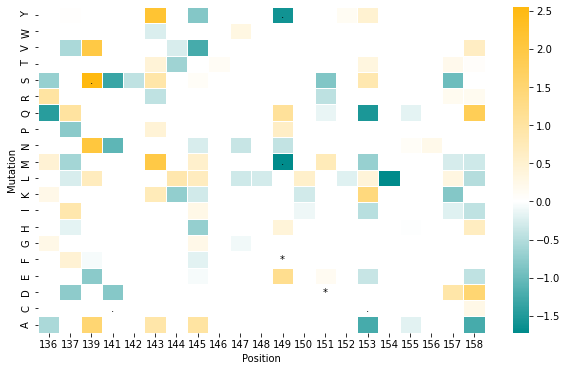

In [234]:
plot_heatmap(fitted_C8)

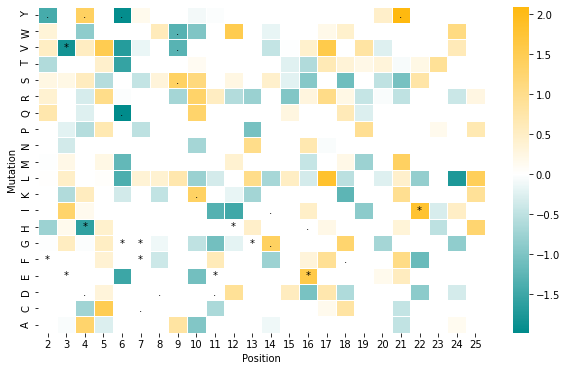

In [235]:
plot_heatmap(fitted_N8)

In [236]:
# add the original raw data to each fitted df to see if the model makes sense
def add_raw_data(df, raw_data):
    # the indicies will not match, so we will need to match the pos and mut columns
    df['pos'] = df['Position'].astype(str)
    df['mut'] = df['Mutation'].astype(str)
    df = df.set_index(['pos', 'mut'])
    df = df[['Coefficient', 'P-value', 'alpha']]

    raw_data['pos'] = raw_data['pos'].astype(str)
    raw_data['mut'] = raw_data['mut'].astype(str)
    raw_data = raw_data.set_index(['pos', 'mut'])
    raw_data = raw_data[['B1_1', 'B2_1', 'B1_2', 'B2_2', 'library']]

    df = df.join(raw_data)
    
    return df

full_C8 = add_raw_data(fitted_C8, C8)
full_N8 = add_raw_data(fitted_N8, N8)

In [237]:
# Find the top 8 mutations with the highest coefficients
def find_top_mutations(ols_results, top_n=8):
    # Find the top 8 mutations with the highest coefficients
    top_mutations = ols_results.sort_values(by='Coefficient', ascending=False).head(top_n)
    top_mutations = top_mutations.append(ols_results.sort_values(by='Coefficient', ascending=True).head(top_n))
    return top_mutations

top_mutations_C8 = find_top_mutations(full_C8)
top_mutations_N8 = find_top_mutations(full_N8)

print(top_mutations_C8)

         Coefficient   P-value alpha    B1_1   B2_1    B1_2    B2_2  library
pos mut                                                                     
139 S       2.553651  0.079348     .     0.1  280.0     0.1   475.0    132.0
143 Y       2.161165  0.112702           0.1   53.0     0.1  1531.0    264.0
139 N       2.050559  0.145933           0.1  280.0    28.0   462.0     68.0
    V       1.977977  0.148691           0.1  261.0     0.1   985.0    288.0
143 M       1.967848  0.168962           0.1  175.0    26.0  1033.0    428.0
158 Q       1.790318  0.187542           0.1  256.0     0.1   530.0    105.0
139 A       1.499605  0.294477         266.0  250.0     0.1   170.0    278.0
158 D       1.487272  0.252990           0.1  457.0     0.1   325.0    118.0
154 L      -1.722052  0.258153          18.0    0.1   386.0     0.1    899.0
149 M      -1.717695  0.081863     .  1077.0    0.1  1386.0     0.1     91.0
    Y      -1.590282  0.096511     .    18.0    0.1   541.0     0.1     66.0

In [238]:
print(top_mutations_N8)

         Coefficient   P-value alpha    B1_1    B2_1    B1_2    B2_2  library
pos mut                                                                      
21  Y       2.093959  0.060053     .     0.1   353.0     0.1    98.0    114.0
17  L       1.822093  0.123081          41.0  1025.0     0.1  2758.0    490.0
22  I       1.798080  0.019353     *     0.1    29.0     0.1    68.0     28.0
16  E       1.578142  0.041211     *     0.1   326.0     0.1   259.0    137.0
17  V       1.567237  0.177701         542.0   733.0     0.1   156.0    194.0
12  W       1.524750  0.181065           0.1   256.0     0.1  1075.0    188.0
5   V       1.506520  0.189853           0.1   249.0     0.1   385.0    210.0
    C       1.504505  0.173001           0.1  1452.0     0.1   111.0     88.0
6   Q      -1.981108  0.071534     .   340.0     0.1     0.1    27.0     63.0
    Y      -1.936971  0.083179     .   266.0    15.0    36.0   451.0     53.0
3   V      -1.835085  0.023228     *  2348.0     0.1   670.0    

## Some notes about above:

I like how this equation is working because the "hits" as listed in the tables above make more sense when looking at the raw data. It turns out that the equation I'm using right now to pick out enzymes with preference is:
```
log2(B2/B1) / log2(L)
```
Where B1, B2, and L are the sequencing counts for binder 1, binder 2 and the unscreened library respectively at each position and mutation. It turns out this can actually be simplified to:
```
logL(B2/B1)
```
Where logL is the *base L log*. Interesting...

This gives positive numbers when B2 is preferred and negative ones when B1 is preferred, and still controls for the number of sequences seen in the library. I thought that this was important because acually rarer mutations that are *still* observed are more important hits.

As of now, the only real purpose of running the GLM on these is to get some aggregation of the two replicate screens that we did. In the future when we are screening enzymes with multiple mutations, GLM will help us deconvolute the important mutations from the non important ones.